In [1]:
import os
import pathlib
import yaml
import numpy
import pandas
import xarray
import h5netcdf
from datetime import datetime
from glob import glob
import time
from matplotlib import pyplot as plt, cm, colors, ticker
#import cartopy.cls
import matplotlib as mpl
mpl.rc('font', size=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

### load runlist used to create aggregated files 

In [2]:
yaml_file=pathlib.Path(
     '/scratch/rmueller/MIDOSS/Results',
     'MOHID_results_locations_27112021_12:05:17.yaml')
with yaml_file.open("rt") as f:
    run_paths = yaml.safe_load(f) 

### Get spill volumes and sort spills to get 5 largest spills by oil type

In [3]:
First100 = {}
for oil in ['diesel','bunker']:
    First100[oil] = run_paths[oil][0:100]

In [4]:
big5_spills={}
for oil in ['diesel','bunker']:
    volume = {}
    volume[oil]={}
    volume[oil]['volume']=[]
    for idx,ncfile in enumerate(First100[oil]):
        directory = "/".join(ncfile.split("/")[:-1]) 
        oil_tag = First100[oil][idx].split('_')[-3]
        # Open the Lagrangian file used for spill
        Lagrangian_file = directory+'/Lagrangian_'+oil_tag+'.dat'
        with open(Lagrangian_file, 'r') as f:
            for line in f:
                if 'POINT_VOLUME              :' in line: 
                    # select spill volume quantity after ':'
                    spillvolume = line.split(':')[-1].split('\n')[0]
                    # convert to float for "sort_values" to work properly
                    volume[oil]['volume'].append(float(spillvolume)) 
        big5_spills[oil] = pandas.DataFrame.from_dict(
            volume[oil]).sort_values('volume',ascending=False)[0:5]

In [5]:
big5_spills

{'diesel':          volume
 30  4953.009484
 12   649.588420
 93   296.522276
 67   210.232635
 72   202.045269,
 'bunker':          volume
 77  3803.779393
 76  2256.047464
 81  1955.231907
 6   1490.015153
 45   683.092967}

In [6]:
%%time
## Generate "TopSpills_df.csv"
## This section takes 10 minutes on 5210 Mb
#vars2plot= ['Dissolution_3D','OilConcentration_3D','OilWaterColumnOilVol_3D']
vars2plot= ['OilWaterColumnOilVol_3D']
vol3d={}
for oil in ['diesel','bunker']:
    vol3d[oil]={}
    # loop through indices of the 5 largest spills in the first 100 spill files
    index = 0
    for idx in big5_spills[oil].index.values:
        spill_xr=xarray.open_dataset(First100[oil][idx])
        vol3d[oil][index]=spill_xr['OilWaterColumnOilVol_3D'][:,39,:,:]
        spill_xr.close()
        index+=1

CPU times: user 1.82 s, sys: 135 ms, total: 1.96 s
Wall time: 3.33 s


In [7]:
vol3d[oil][0]

<xarray.DataArray 'OilWaterColumnOilVol_3D' (time: 168, grid_y: 896, grid_x: 396)>
[59609088 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2018-06-17T00:30:00 ... 2018-06-23T23:30:00
  * grid_y   (grid_y) int16 0 1 2 3 4 5 6 7 ... 888 889 890 891 892 893 894 895
  * grid_x   (grid_x) int16 0 1 2 3 4 5 6 7 ... 388 389 390 391 392 393 394 395
    grid_z   int16 39
Attributes:
    standard_name:  OilWaterColumnOilVol_3D
    long_name:      OilWaterColumnOilVol_3D
    units:          m3/gridcell

### Plot up surface volume of first 5 spills

In [8]:
vol3d[oil][0].attrs

{'standard_name': 'OilWaterColumnOilVol_3D',
 'long_name': 'OilWaterColumnOilVol_3D',
 'units': 'm3/gridcell'}

### Graphic specifications

In [9]:
surface_threshold = 3e-3
bins = numpy.arange(surface_threshold,1500,50)

### Plot Histogram of 3d volume

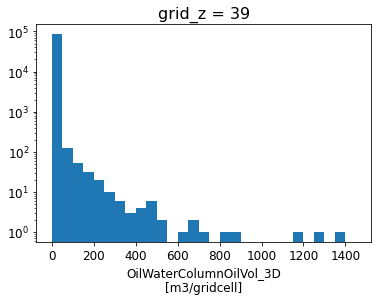

In [10]:
axs=vol3d[oil][0].where(vol3d[oil][0]>surface_threshold).plot.hist(bins=bins,log=True)

### Plot histogram of 3d volume integrated over time

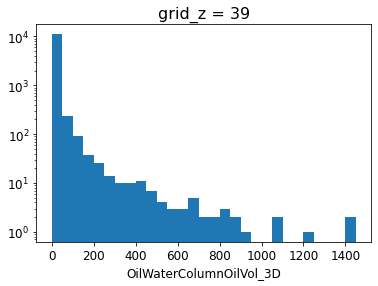

In [11]:
axs = vol3d[oil][0].where(vol3d[oil][0]>surface_threshold).sum(
    dim='time', skipna=True).plot.hist(bins=bins,log=True)

### Plot historgram of log-transformed 3d volume, integrated over time

In [12]:
# first log-transpose then sum over time
vol3d_ln=numpy.log(
    vol3d[oil][0].where(vol3d[oil][0]>surface_threshold)
).sum(dim='time',skipna=True)
# first sum over time and then log-transpose
vol3d_sumt=vol3d[oil][0].where(vol3d[oil][0]>surface_threshold).sum(dim='time',skipna=True)
vol3d_sumt_ln=numpy.log(
    vol3d_sumt.where(vol3d_sumt>0)
)

In [13]:
numpy.exp(vol3d_ln).max().values.item()

1.722525208178137e+16

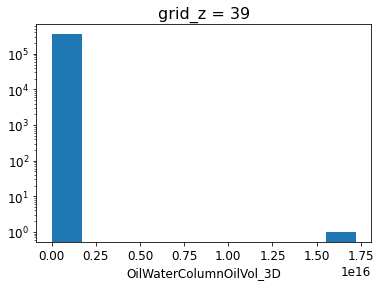

In [14]:
axs = numpy.exp(vol3d_ln).plot.hist(log=True)

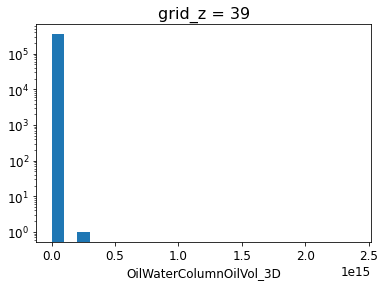

In [15]:
bins_ln = numpy.arange(surface_threshold,2.5e15,0.1e15)
axs = numpy.exp(vol3d_ln).plot.hist(bins=bins_ln,log=True)

### Plot historgram of 3D integrated volume, log-transformed 
- Note: In this case this graphic represents exp(ln(X)) and ought to be the same as [11]

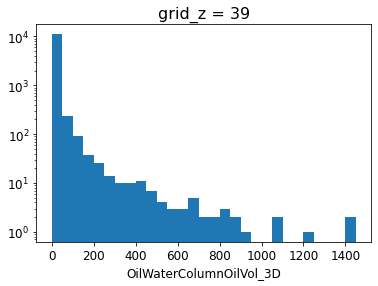

In [16]:
axs = numpy.exp(vol3d_sumt_ln).plot.hist(bins=bins,log=True)

In [17]:
numpy.exp(vol3d_sumt_ln).min().values.item()

0.358

In [18]:
vol3d_sumt.where(vol3d_sumt>0).min().values.item()

0.35800000000000004

### Validate time aggregation method

In [22]:
sfc_vol_threshold = 3e-3
nruns=len(vol3d[oil])
#dims=nruns
[nt,ny,nx]=vol3d[oil][0].shape

dims=('nspills','grid_y','grid_x')
MOHID_In=xarray.Dataset(
    data_vars=dict(
        SurfacePresence=(dims, numpy.zeros((nruns,ny,nx),dtype=int)),
        SurfacePresence_24h=(dims, numpy.zeros((nruns,ny,nx),dtype=int)),
        SurfacePresence_24h_to_72h=(dims, numpy.zeros((nruns,ny,nx),dtype=int)),
        SurfacePresence_72h_to_168h=(dims, numpy.zeros((nruns,ny,nx),dtype=int)),
        SurfaceVolumeSum=(dims, numpy.zeros((nruns,ny,nx),dtype=float)),
        SurfaceVolumeMax=(dims, numpy.zeros((nruns,ny,nx),dtype=float)),
        SurfaceVolumeSum_24h=(dims, numpy.zeros((nruns,ny,nx),dtype=float)),
        SurfaceVolumeSum_24h_to_72h=(dims, numpy.zeros((nruns,ny,nx),dtype=float)),
        SurfaceVolumeSum_72h_to_168h=(dims, numpy.zeros((nruns,ny,nx),dtype=float)),
        SurfaceConcentrationSum=(dims, numpy.zeros((nruns,ny,nx),dtype=float))
    ),
    coords=dict(
        grid_y=range(ny),
        grid_x=range(nx))
)


In [51]:
oil

'bunker'

In [23]:
SurfaceVolumeSum=numpy.zeros((nruns,ny,nx),dtype=float)
SurfaceVolumeMax=numpy.zeros((nruns,ny,nx),dtype=float)
SurfaceVolumeSum_24h=numpy.zeros((nruns,ny,nx),dtype=float)
SurfaceVolumeSum_24h_to_72h=numpy.zeros((nruns,ny,nx),dtype=float)
SurfaceVolumeSum_72h_to_168h=numpy.zeros((nruns,ny,nx),dtype=float)
for idx in vol3d[oil]:
    spill_start = vol3d[oil][idx].time[0]
    spill_end = vol3d[oil][idx].time[-1]
    # define time thresholds
    one_day=numpy.timedelta64(24,'h')
    three_days=numpy.timedelta64(48,'h')
    seven_days=numpy.timedelta64(168,'h')
    # Select surface volume, concentration and dissolution
    vol3d_orig=vol3d[oil][idx]
    # Sum volume over time where volume is greater than threshold
    vol3d_sumt = vol3d_orig.where(vol3d_orig>sfc_vol_threshold).sum(
            dim="time",skipna=True)
    # 3d volume above threshold limits
    vol3dthresh = vol3d_orig.where(vol3d_orig>sfc_vol_threshold)
    #~~~ Without log transforme ~~~ 
    MOHID_In.SurfaceVolumeSum[idx,:,:]=vol3d_sumt
    MOHID_In.SurfaceVolumeSum_24h[idx,:,:]=vol3dthresh.loc[
        dict(time=slice(spill_start,spill_start+one_day))
        ].sum(dim="time",skipna=True)
    MOHID_In.SurfaceVolumeSum_24h_to_72h[idx,:,:]=vol3dthresh.loc[
        dict(time=slice(
            spill_start+one_day,spill_start+three_days))
        ].sum(dim="time",skipna=True)
    MOHID_In.SurfaceVolumeSum_72h_to_168h[idx,:,:]=vol3dthresh.loc[
        dict(time=slice(
            spill_start+three_days,spill_start+seven_days))
        ].sum(dim="time",skipna=True)
    

### straight sum

In [24]:
SurfaceOut = {}
SurfaceOut['SurfaceVolume_SumSum']=MOHID_In.SurfaceVolumeSum.sum(
    dim='nspills', skipna=True)    
SurfaceOut['SurfaceVolume_SumSum_24h']=MOHID_In.SurfaceVolumeSum_24h.sum(
    dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_SumSum_24h_to_72h']=MOHID_In.SurfaceVolumeSum_24h_to_72h.sum(
    dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_SumSum_72h_to_168h']=MOHID_In.SurfaceVolumeSum_72h_to_168h.sum(
    dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_MaxSum']=MOHID_In.SurfaceVolumeMax.sum(
    dim='nspills', skipna=True)

### log transpose first then sum 

In [25]:
SurfaceOut['SurfaceVolume_SumSum_ln']=numpy.log(
   MOHID_In.SurfaceVolumeSum.where(MOHID_In.SurfaceVolumeSum>0)
).sum(dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_SumSum_24h_ln']=numpy.log(
   MOHID_In.SurfaceVolumeSum_24h.where(MOHID_In.SurfaceVolumeSum_24h>0)
).sum(dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_SumSum_24h_to_72h_ln']=numpy.log(
   MOHID_In.SurfaceVolumeSum_24h_to_72h.where(
       MOHID_In.SurfaceVolumeSum_24h_to_72h>0)
).sum(dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_SumSum_72h_to_168h_ln']=numpy.log(
   MOHID_In.SurfaceVolumeSum_72h_to_168h.where(
       MOHID_In.SurfaceVolumeSum_72h_to_168h>0)
).sum(dim='nspills', skipna=True)
SurfaceOut['SurfaceVolume_MaxSum_ln']=numpy.log(
    MOHID_In.SurfaceVolumeMax.where(
    MOHID_In.SurfaceVolumeMax>0)).sum(dim='nspills', skipna=True)

## Plot 5 largest bunker spills
- histogram of surface volume of all 5 spills
- histogram of straight sum of surface volume
- histogram of geometric sum (for lack of a better term)

(0.7, 500000.0)

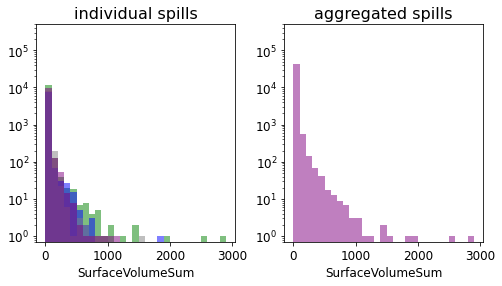

In [48]:
bins = numpy.arange(surface_threshold,3000,100)
color=['green','blue','grey','purple']
fig, axs = plt.subplots(1, 2, figsize=(8, 4), 
                        gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
for idx in numpy.arange(0,4):
    MOHID_In.SurfaceVolumeSum[idx,:,:].plot.hist(ax=axs[0],log=True, bins=bins,alpha=0.5, color=color[idx])
MOHID_In.SurfaceVolumeSum.plot.hist(ax=axs[1],log=True, bins=bins,alpha=0.5, color=color[idx])
axs[0].set_title('individual spills')
axs[0].set_ylim(7e-1, 5e5)
axs[1].set_title('aggregated spills')
axs[1].set_ylim(7e-1, 5e5)

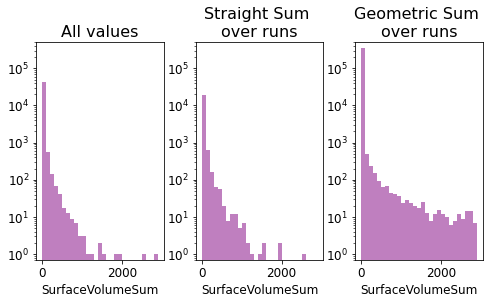

In [50]:
%matplotlib inline    
fig, axs = plt.subplots(1, 3, figsize=(8, 4), 
                        gridspec_kw={'wspace': 0.25, 'hspace': 0.1})
MOHID_In.SurfaceVolumeSum.plot.hist(ax=axs[0],log=True, bins=bins,alpha=0.5, color=color[idx])
SurfaceOut['SurfaceVolume_SumSum'].plot.hist(ax=axs[1],log=True, bins=bins,alpha=0.5, color=color[idx])
numpy.exp(SurfaceOut['SurfaceVolume_SumSum_ln']).plot.hist(ax=axs[2],log=True, bins=bins,alpha=0.5, color=color[idx])
axs[0].set_title(f'All values')
axs[1].set_title(f'Straight Sum \nover runs')
axs[2].set_title(f'Geometric Sum \nover runs')
for idx in [0,1,2]:
    axs[idx].set_ylim(7e-1, 5e5)